In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# for n in range (1,11,1):
#     plt.close('all')
#     data=np.genfromtxt('CW32_Train{}_impactenergy.csv'.format(n), delimiter=',')
#     plt.pcolormesh(data)
#     plt.colorbar()
#     #plt.clim(0,30)
#     plt.savefig('CW32_Train{}_impactenergy.png'.format(n))

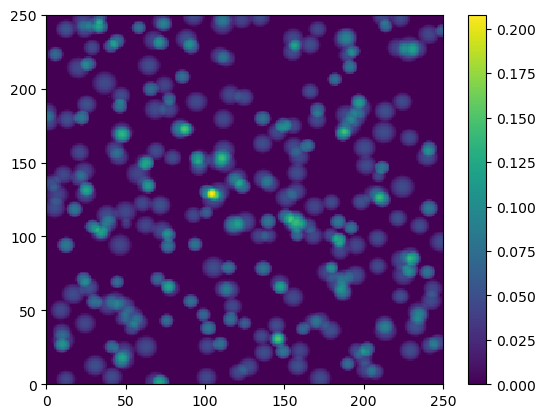

In [17]:
data=np.genfromtxt('CW32_Test1_impactenergy.csv', delimiter=',')
plt.pcolormesh(data)
plt.colorbar()

In [2]:
def rotate_180(array, M, N, out):
    for i in range(M):
        for j in range(N):
            out[i, N-1-j] = array[M-1-i, j]


def surf_stress_file(name):

    data=pd.read_csv('{}.csv'.format(name))
    data.rename(columns = {'S-Max. Principal (Abs)':'stress'}, inplace = True)
    data=data.drop(columns=['ODB Name' , 'Step' ,'Frame', 'Part Instance Name', 'Section Name', 'Material Name', 'Section Point'])
    data = data.sort_values(by=['X', 'Y','Z'], ascending=False)
    datamatrix=np.array(data)
    #############################################################################
    stressmatrix=np.empty((2016032,4))
    for n in range (1,22176352,11):
        stressmatrix[int((n-1)/11),0]=datamatrix[n,1]
        stressmatrix[int((n-1)/11),1]=datamatrix[n,2]
        stressmatrix[int((n-1)/11),2]=datamatrix[n,3]
        stressmatrix[int((n-1)/11),3]=np.average(datamatrix[n-1:n+9,4])

    stressmatrix=pd.DataFrame(stressmatrix, columns=['X','Y','Z','stress'])
    stressmatrix=stressmatrix.sort_values(by=['Z','Y','X'], ascending=False)
    stressmatrix1=np.array(stressmatrix.stress)
    stressmatrixx=np.array(stressmatrix.X)
    stressmatrixy=np.array(stressmatrix.Y)

    #stressmatrix
    stressfield=np.empty((251,251))
    for n in range (0,251,1):
        for d in range (0,251,1):
            stressfield[n,d]=stressmatrix1[int(d+(n*251))]
    rotatedstressfield=np.empty((251,251))
    rotate_180(stressfield, 251, 251, rotatedstressfield)
    np.savetxt('{}_surfstress.csv'.format(name), rotatedstressfield, delimiter=',')

#calculates incersection between a pair of polygons
def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_2.intersection(poly_1).area / poly_1.union(poly_2).area
    proportion=poly_2.area/(poly_1.union(poly_2).area)
    return (iou/proportion)

#creates a map (250x250 martrix) with the number of impacts that occur on each element surface of the FEA model

def impactdensity(name):
    data=pd.read_csv("{}.txt".format(name))
    #gridx=np.linspace(0,5,250)
    #gridy=np.linspace(0,5,250)
    gridx=np.linspace(0,5,251)
    gridy=np.linspace(0,5,251)
    impactsperpt=np.empty((250,250))
    for n in range (0,len(gridx)-1,1):
        for m in range (0,len(gridy)-1,1):
            runningtotal=0
            for p in range (0,len(data.x),1):
                box=[[gridx[n],gridy[m]],[gridx[n],gridy[m+1]],[gridx[n+1],gridy[m+1]],[gridx[n+1],gridy[m]]]
                circle=Point(data.x[p],data.y[p]).buffer(data.impactdiameter[p]/2)
                intersect=calculate_iou(box,circle)
                if intersect != 0:
                    runningtotal=runningtotal+1
            impactsperpt[m,n]=runningtotal
    return(impactsperpt)

def impactfield(name):
    densityfield=impactdensity("{}".format(name))
    np.savetxt('{}_densityplt.csv'.format(name), densityfield, delimiter=',')
    

#creates a map (250x250 martrix) with the amount of energy imparted on each element surface of the FEA model

def impactenergy(name):
    data=pd.read_csv("{}.txt".format(name))
    #gridx=np.linspace(0,5,250)
    #gridy=np.linspace(0,5,250)
    gridx=np.linspace(0,5,251)
    gridy=np.linspace(0,5,251)
    impactsperpt=np.empty((250,250))
    for n in range (0,len(gridx)-1,1):
        for m in range (0,len(gridy)-1,1):
            runningtotal=0
            for p in range (0,len(data.x),1):
                box=[[gridx[n],gridy[m]],[gridx[n],gridy[m+1]],[gridx[n+1],gridy[m+1]],[gridx[n+1],gridy[m]]]
                circle=Point(data.x[p],data.y[p]).buffer(data.impactdiameter[p]/10)
                intersect=calculate_iou(box,circle)
                if intersect != 0:
                    runningtotal=runningtotal+((0.5*(4/3)*np.pi*(7.98*10**-9)*((data.AreaEqDiameter[p]/2)**3)*(65000**2)*((0.02**2)/(np.pi*((data.impactdiameter[p]/10)**2)))))
                    #calculate proportion of impact energy per cell^
            impactsperpt[m,n]=runningtotal
    return(impactsperpt)




def impactenergyfile1(name):
    energyfield=impactenergy("{}".format(name))
    np.savetxt('{}_energyplt.csv'.format(name), energyfield, delimiter=',')

def vlocal(x_star,y_star,a,radius,areaeqdiameter,velocity):
    x_grid=(np.linspace(0,249,250)*0.02)+0.01
    y_grid=(np.linspace(0,249,250)*0.02)+0.01
    h=-np.sqrt((radius**2)-(a**2))+radius
    if np.isnan(h)==1:
        h=0
    if np.isinf(h) == 1:
        h=0
    

    e_total=((0.5*(4/3)*np.pi*(7.98*10**-9)*((areaeqdiameter/2)**3)*(velocity**2)))
    v_total=(1/3)*np.pi*(h**2)*((3*radius)-h)
    sf=e_total/v_total
    v=np.zeros((250,250))
    for n in range (0,250,1):
        for p in range (0,250,1):
            z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)
            if z < 0:
                z=0
            if np.isnan(z)==1:
                z=0
            if np.isinf(z) == 1:
                x=0
            v[n,p]=z*0.02*0.02*sf




    #z=(np.sqrt((radius**2)-(x**2)+(2*x*x_star)-(x_star**2)-(y**2)+(2*y*y_star)-(y_star**2)))-(radius-h)
    #v=z*0.02*0.02
    #consider whether or not to include if statement to weed out negative values
    #negative values could be a predictor for regions of tension??
    isthevaluenan=np.isnan(v)
    v[isthevaluenan]=0

    return(v)

def impactenergyfile(name,velocity):
    data=pd.read_csv("{}.txt".format(name))
    energyplot=np.zeros((250,250))
    energytemp=np.zeros((250,250,data.shape[0]))
    for n in range (0, data.shape[0],1):
        a=0.11442655*(((0.5*(4/3)*np.pi*(7.98*10**-9)*((data.AreaEqDiameter[n]/2)**3)*(velocity**2)))**0.28999685)*((data.impactdiameter[n])**0.33790162)
        energytemp[:,:,n]=vlocal(x_star=data.x[n],y_star=data.y[n],a=a,radius=data.impactdiameter[n]/2, areaeqdiameter=data.AreaEqDiameter[n], velocity=velocity)
        
    energyplot=np.sum(energytemp, axis=2)
        
    energyplot=energyplot.T

    np.savetxt('{}_impactenergy.csv'.format(name), energyplot, delimiter=',')
        



In [3]:
surf_stress_file('CW28_0945_20_49100_65000_90_Week1')

In [21]:
for n in range(1,11):
    impactenergyfile('CW32_Train{}'.format(n),65000)
    print(n)

/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)
/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:67: RuntimeWarning: invalid value encountered in sqrt
  h=-np.sqrt((radius**2)-(a**2))+radius
/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  sf=e_total/v_total
/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:87: RuntimeWarning: invalid value encountered in double_scalars
  v[n,p]=z*0.02*0.02*sf


1


/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)


2


/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)


3


/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)


4


/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)


5


/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)


6


/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)


7


/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)
/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:67: RuntimeWarning: invalid value encountered in sqrt
  h=-np.sqrt((radius**2)-(a**2))+radius
/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  sf=e_total/v_total
/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:87: RuntimeWarning: invalid value encountered in double_scalars
  v[n,p]=z*0.02*0.02*sf


8


/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)


9


/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_75584/1583023852.py:80: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)


10


In [3]:
import pandas as pd

data=pd.read_csv('CW32_Test2.txt')
energyplot=np.zeros((250,250))
velocity=65000

energytemp=np.zeros((250,250,data.shape[0]))
for n in range (0, data.shape[0],1):
        a=0.11442655*(((0.5*(4/3)*np.pi*(7.98*10**-9)*((data.AreaEqDiameter[n]/2)**3)*(velocity**2)))**0.28999685)*((data.impactdiameter[n])**0.33790162)
        energytemp[:,:,n]=vlocal(data.x[n],data.y[n],a,data.impactdiameter[n]/2, data.AreaEqDiameter[n], velocity)
        #energyplot=energyplot+energytemp



/var/folders/z0/_ky4gjk134j8xr5wp58gfm6h0000gn/T/ipykernel_54461/4180855240.py:116: RuntimeWarning: invalid value encountered in sqrt
  z=(np.sqrt((radius**2)-(x_grid[n]**2)+(2*x_grid[n]*x_star)-(x_star**2)-(y_grid[p]**2)+(2*y_grid[p]*y_star)-(y_star**2)))-(radius-h)


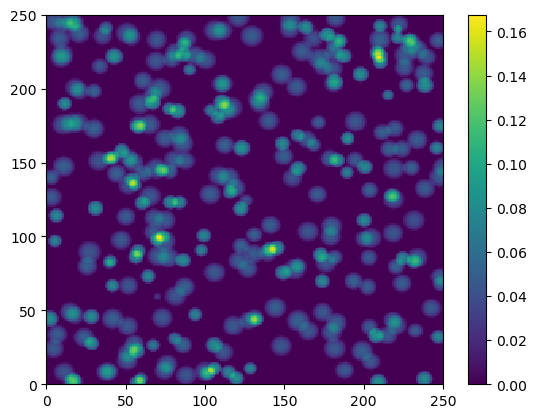

In [9]:
data2=np.sum(energytemp, axis=2)
plt.pcolormesh(data2)
plt.colorbar()

In [17]:
#Takes in the name, file number (for sets of multiple training and test data files), and the desired width of the training dataset matrix
#Opens the surface stress field from the FEA model (251x251 matrix- stress at each node on the surface)
#Iterates accross the surface of the part and isolates every region of size (numcells x numcells), then reshapes it to size (numcells**2)
#Each row of the table is a set of inputs
#The stress at the center of each (numcells x numcells) region is saved in a seperate table, each row of the stress cooresponds to the training target
#The average stresses has the same format, but instead of the stress at the center of the matrix, it is the average of the stress values of all nodes that make up the region

def gentestdata(name, numfile, numcells):
    densitydata=np.genfromtxt('{}{}_impactenergy.csv'.format(name,numfile), delimiter=',')
    stressdata=np.genfromtxt('{}{}_surfstress.csv'.format(name,numfile), delimiter=',')

    flatstress=np.array([])
    averagestress=np.empty(((numcells+1)**2,(int(len(densitydata)-numcells)+1)**2))
    flatdensity=np.empty((numcells**2,(int(len(densitydata)-numcells)+1)**2))
    tempdensity=np.empty((numcells,numcells))

    for n in range(0,int(len(densitydata)-numcells)+1):
        for p in range (0,int(len(densitydata)-numcells)+1):
            tempdensity[:,:]=densitydata[n:n+numcells, p:p+numcells]
            tempstress=stressdata[int(n+numcells/2), int(p+numcells/2)]
            flatstress=np.append(flatstress,tempstress)
            flatdensity[:,p+(n*(len(densitydata)-numcells+1))]=tempdensity.reshape((numcells**2,1)).flatten()
            averagestress[:,p+(n*(len(densitydata)-numcells+1))]=stressdata[n:n+numcells+1,p:p+numcells+1].reshape(((numcells+1)**2,1)).flatten()


    averagestresses=np.average(averagestress,axis=0)

    return(flatdensity,flatstress,averagestresses)


In [84]:
#Generates the test and training data for all 10 datasets

testdensity, teststress, testavgstress = gentestdata('CW32_Test',1,4)
testdensity=testdensity.T
fulltestdensity=np.empty((10*testdensity.shape[0],testdensity.shape[1]))
fullteststress=np.empty((10*teststress.shape[0]))
fulltestavgstress=np.empty((10*testavgstress.shape[0]))
for n in range (1,11):
    testdensity1, teststress1, testavgstress1 = gentestdata('CW32_Test',n,4)
    testdensity1=testdensity1.T
    fulltestdensity[(n-1)*testdensity.shape[0]:n*testdensity.shape[0],:]=testdensity1
    fullteststress[(n-1)*teststress1.shape[0]:n*teststress1.shape[0]]=teststress1
    fulltestavgstress[(n-1)*testavgstress1.shape[0]:n*testavgstress1.shape[0]]=testavgstress1

# trainingdensity, trainingstress, trainavgstress = gentestdata('CW32_Train',1,30)
# trainingdensity=trainingdensity.T
# fulltrainingdensity=np.empty((10*trainingdensity.shape[0],trainingdensity.shape[1]))
# fulltrainingstress=np.empty((10*trainingstress.shape[0]))
# fulltrainavgstress=np.empty((10*trainavgstress.shape[0]))
# for n in range (1,11):
#     trainingdensity1, trainingstress1, trainavgstress1 = gentestdata('CW32_Train',n,30)
#     trainingdensity1=trainingdensity1.T
#     fulltrainingdensity[(n-1)*trainingdensity.shape[0]:n*trainingdensity.shape[0],:]=trainingdensity1
#     fulltrainingstress[(n-1)*trainingstress1.shape[0]:n*trainingstress1.shape[0]]=trainingstress1
#     fulltrainavgstress[(n-1)*trainavgstress1.shape[0]:n*trainavgstress1.shape[0]]=trainavgstress1



In [19]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import models
from keras import layers

2023-01-29 22:52:33.682187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
#defines the model, 3 layers, 4 nodes on the first 2, 1 node on the output, with a linear activation energy so that the model can output negative numbers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(512, activation='elu',
                           input_shape=(trainingdensity.shape[1],)))
    
    model.add(layers.Dense(512, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dense(64, activation='elu'))


    model.add(layers.Dense(1))
    model.compile(optimizer='Nadam', loss='mse', metrics=['mae'])
    return model

In [23]:
model = build_model()
model.fit(fulltestdensity, fullteststress,epochs=30, batch_size=1000, verbose=1)
#val_mse, val_mae = model.evaluate(fulltestdensity, fullteststress, verbose=1)

NameError: name 'models' is not defined

1907/1907 [==============================] - 1s 418us/step


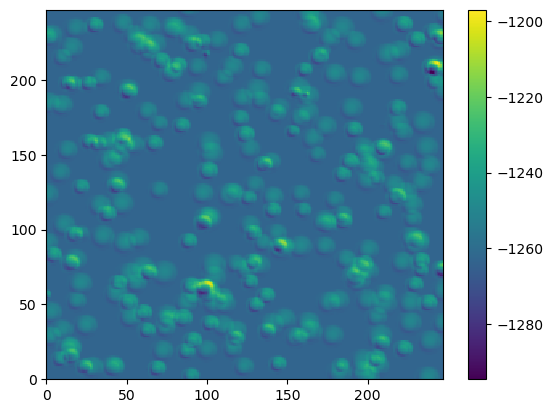

In [88]:
trialdensity, trialstress, trialavgstress=gentestdata('CW32_Test', 3, 4)
trialdensity=trialdensity.T

data=model.predict(trialdensity)
data=data.reshape((int(np.sqrt(len(data))),int(np.sqrt(len(data)))))
plt.pcolormesh(data)
plt.colorbar()